Test script

CoolTerm: Gemt Serial Moniter data som .txt fil

# 61g: Signal Processing and Power Spectrum Analysis



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Indlæs filen
file_path = "/Users/linnthomsen/Desktop/Skole/DTU/6thSemester/BA/FSR_software/Mass_FSR_analog/61g.txt"
data = np.loadtxt(file_path, delimiter=",")
time_ms = data[:, 0]
signal = data[:, 1]

# Beregn og print statistik
mean_analog = np.mean(signal)
std_dev = np.std(signal)
print(f"Mean analogRead: {mean_analog:.2f}")
print(f"Standardafvigelse: {std_dev:.2f}")
print(f"Relative standard deviation: {100 * np.std(signal) / np.mean(signal):.2f}%")


# >>> Her indsætter du moving average-funktionen:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

smooth = moving_average(signal, 10)

# Tid skal forkortes tilsvarende (fordi signalet bliver kortere)
time_smooth = time_ms[:len(smooth)]

# Plot originalt og glattet signal
plt.figure(figsize=(10, 4))
plt.plot(time_ms, signal, label="Originalt signal", alpha=0.5)
plt.plot(time_smooth, smooth, label="Glattet signal (w=10)", linewidth=2)
plt.xlabel("Tid (ms)")
plt.ylabel("analogRead")
plt.title("Signal over tid – glat versus original")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


FileNotFoundError: /Users/linnthomsen/Desktop/Skole/DTU/6thSemester/BA/FSR_software/Mass_FSR_analog/61g.txt not found.

The signal fluctuates about ±5.6% around its average value

## Power Spectrum Analysis

Sample rate: 100.00 Hz
Mean of analogRead: 195.21
Mean in Voltage: 0.16 V
Kraft = 0.5984 N


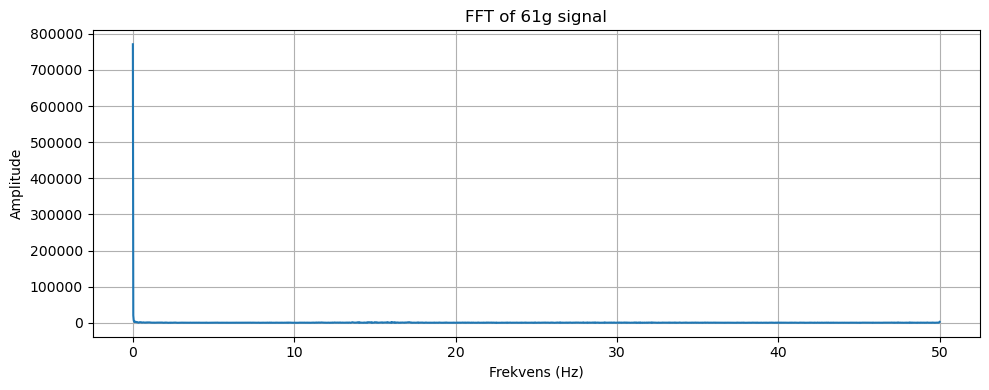

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Indlæs .txt-filen
file_path = "/Users/linnthomsen/Desktop/Skole/DTU/6thSemester/BA/FSR_software/Mass_FSR_analog/61g.txt"
data = np.loadtxt(file_path, delimiter=",")  # Indlæser begge kolonner

time_ms = data[:, 0]
signal = data[:, 1]

# 2. Beregn sampling rate (fs) fra tid (i millisekunder)
time_s = time_ms / 1000  # konverter til sekunder
dt = np.mean(np.diff(time_s))  # gennemsnitligt sample-interval
fs = 1 / dt  # sample rate i Hz
print(f"Sample rate: {fs:.2f} Hz")

# 3. FFT
N = len(signal)
fft_vals = np.fft.fft(signal)        # Kompleks tal som viser styrken ved hver frekvens
fft_freqs = np.fft.fftfreq(N, d=dt)  # Frekvenserne i Hz, der matcher hvert punkt i FFT’en

# 4. Kun positive frekvenser
pos_mask = fft_freqs >= 0 # Fordi signalet er reelt (ikke kompleks), er FFT spejlet. Viser kun den ene halvdel (positiv frekvens)
fft_freqs = fft_freqs[pos_mask]
fft_magnitude = np.abs(fft_vals[pos_mask])

# 5. Beregn middelværdi
mean_analog = np.mean(signal)
print(f"Mean of analogRead: {mean_analog:.2f}")

mean_voltage = mean_analog * 3.3 / 4095
print(f"Mean in Voltage: {mean_voltage:.2f} V")

Mass = 61
print(f"Kraft = {Mass * 0.00981:.4f} N")


# 6. Plot
plt.figure(figsize=(10, 4))
plt.plot(fft_freqs, fft_magnitude)
plt.title("FFT of 61g signal")
plt.xlabel("Frekvens (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


Hvad betyder den store spike ved 0 Hz?

Det betyder, at signalet har en langsigtet komponent, som ændrer sig meget langsomt – typisk kaldet 'DC drift'. Det er ikke nødvendigvis støj, men kan være en faktisk ændring i trykket eller sensorens respons.

## Filtrere for at kunne se andet end DC støj

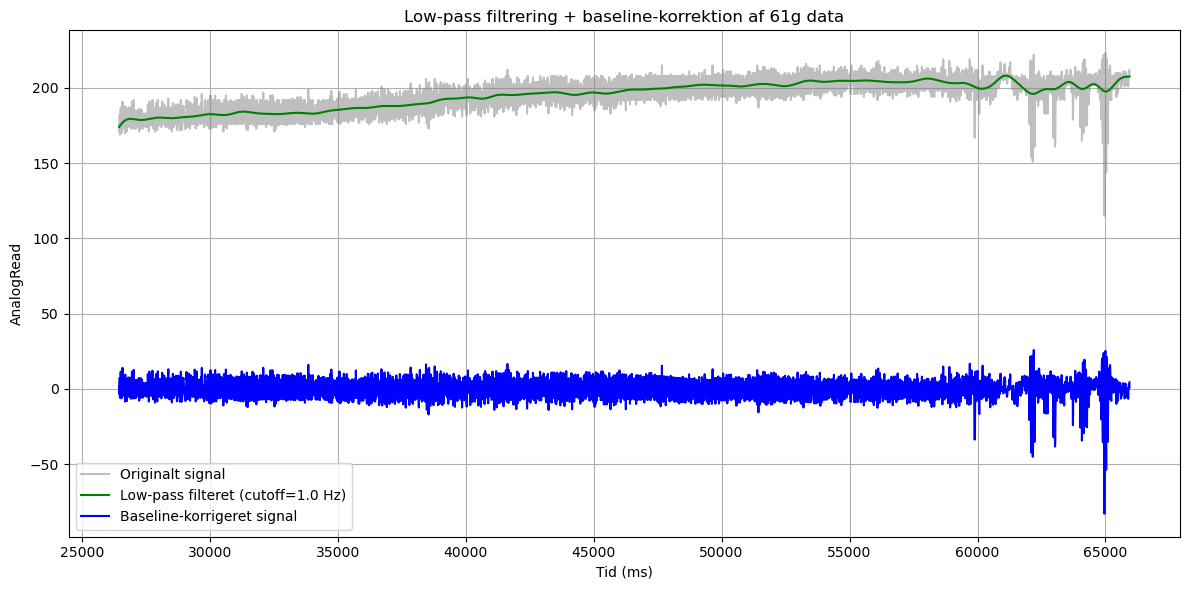

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# === 1. Indlæs dine data ===
file_path = "/Users/linnthomsen/Desktop/Skole/DTU/6thSemester/BA/FSR_software/Mass_FSR_analog/61g.txt"
data = np.loadtxt(file_path, delimiter=",")
time_ms = data[:, 0]
signal = data[:, 1]

# === 2. Design et low-pass filter ===
def lowpass_filter(signal, cutoff_hz, fs_hz, order=4):
    nyquist = 0.5 * fs_hz
    normal_cutoff = cutoff_hz / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Sampling rate (antal samples per sekund)
# Beregnes ud fra tidsstempler
sampling_interval = np.mean(np.diff(time_ms)) / 1000  # ms → s
fs = 1 / sampling_interval

# === 3. Low-pass filtrer signalet ===
cutoff = 1.0  # Hz (justér efter behov)
filtered_signal = lowpass_filter(signal, cutoff_hz=cutoff, fs_hz=fs)

# === 4. Baseline-korrektion ===
# Fjern den langsomme drift (DC) ved at trække den filtrerede version fra originalen
baseline_corrected = signal - filtered_signal

# === 5. Plot ===
plt.figure(figsize=(12, 6))
plt.plot(time_ms, signal, label="Originalt signal", alpha=0.5, color="gray")
plt.plot(time_ms, filtered_signal, label=f"Low-pass filteret (cutoff={cutoff} Hz)", color="green")
plt.plot(time_ms, baseline_corrected, label="Baseline-korrigeret signal", color="blue")
plt.xlabel("Tid (ms)")
plt.ylabel("AnalogRead")
plt.title("Low-pass filtrering + baseline-korrektion af 61g data")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Low-pass vs High-pass filtering

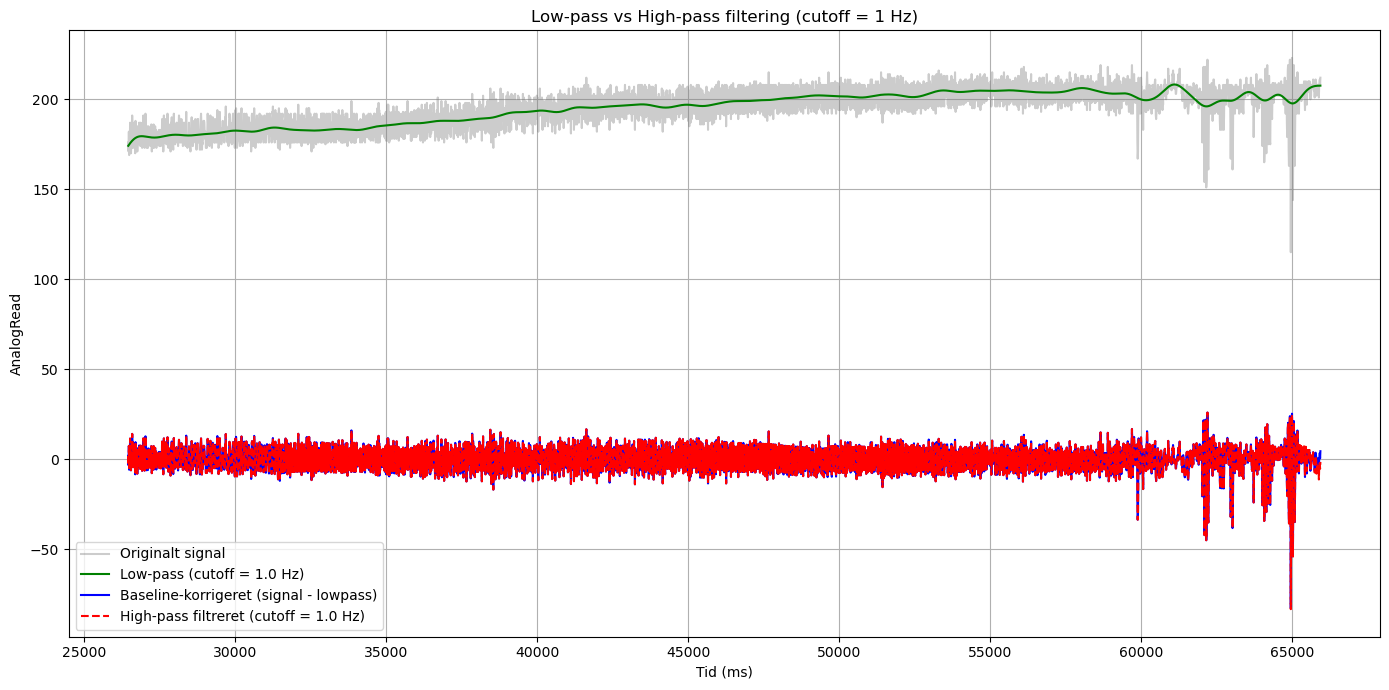

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# === 1. Indlæs dine data ===
file_path = "/Users/linnthomsen/Desktop/Skole/DTU/6thSemester/BA/FSR_software/Mass_FSR_analog/61g.txt"
data = np.loadtxt(file_path, delimiter=",")
time_ms = data[:, 0]
signal = data[:, 1]

# === 2. Design low-pass og high-pass filtre ===
def lowpass_filter(signal, cutoff_hz, fs_hz, order=4):
    nyquist = 0.5 * fs_hz
    normal_cutoff = cutoff_hz / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

def highpass_filter(signal, cutoff_hz, fs_hz, order=4):
    nyquist = 0.5 * fs_hz
    normal_cutoff = cutoff_hz / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# === 3. Beregn sampling rate ===
sampling_interval = np.mean(np.diff(time_ms)) / 1000  # ms → s
fs = 1 / sampling_interval

# === 4. Filtrér signalet ===
cutoff = 1.0  # Hz
lowpass = lowpass_filter(signal, cutoff_hz=cutoff, fs_hz=fs)
baseline_corrected = signal - lowpass

highpass = highpass_filter(signal, cutoff_hz=cutoff, fs_hz=fs)

# === 5. Plot ===
plt.figure(figsize=(14, 7))

plt.plot(time_ms, signal, label="Originalt signal", alpha=0.4, color="gray")
plt.plot(time_ms, lowpass, label=f"Low-pass (cutoff = {cutoff} Hz)", color="green")
plt.plot(time_ms, baseline_corrected, label="Baseline-korrigeret (signal - lowpass)", color="blue")
plt.plot(time_ms, highpass, label=f"High-pass filtreret (cutoff = {cutoff} Hz)", color="red", linestyle="--")

plt.xlabel("Tid (ms)")
plt.ylabel("AnalogRead")
plt.title("Low-pass vs High-pass filtering (cutoff = 1 Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Visuelt ses at både det high-pass filtrerede signal (rødt) og baseline-korrektionen (blåt) fjerner den langsomme drift og fremhæver de hurtige variationer. Det viser, at vi kan bruge enten et dedikeret high-pass filter eller blot trække et lavfrekvent estimat fra.  Resultatet bliver næsten det samme

## Power Spectrum for baseline-korigeret signal

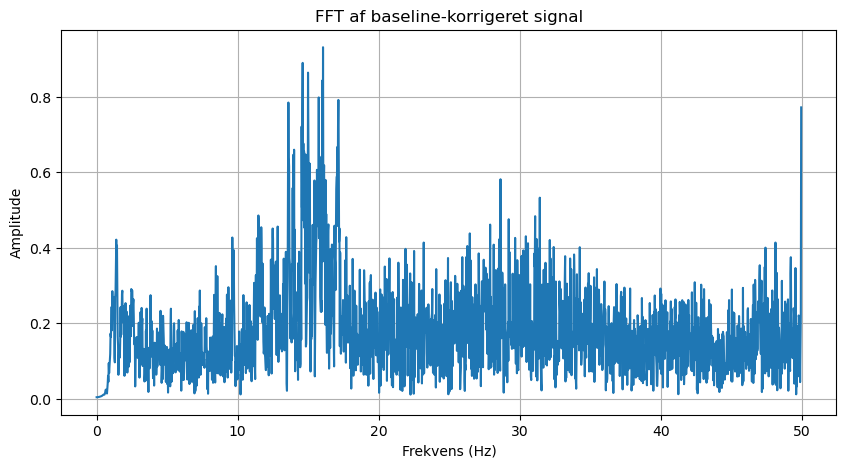

In [15]:
from scipy.fft import fft, fftfreq

N = len(baseline_corrected)
T = (time_ms[1] - time_ms[0]) / 1000  # sample-tid i sekunder

yf = fft(baseline_corrected)
xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(10,5))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title("FFT af baseline-korrigeret signal")
plt.xlabel("Frekvens (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()




# 122g: Signal Processing and Power Spectrum Analysis

Mean analogRead: 1273.13
Standardafvigelse: 31.09
Relative standard deviation: 2.44%


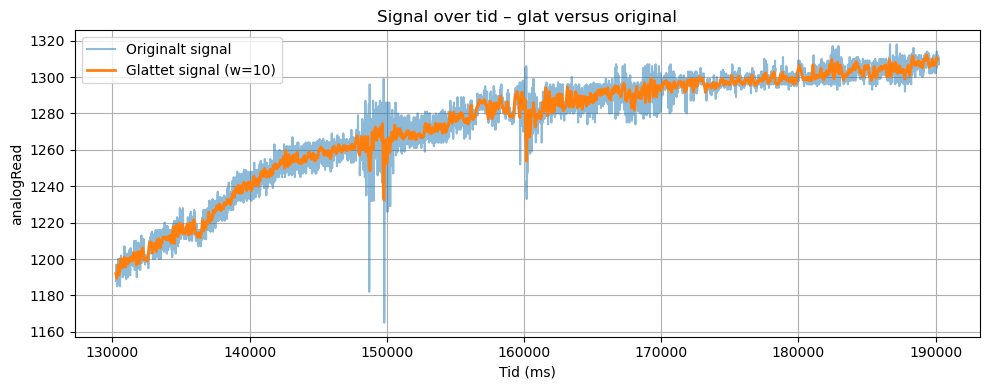

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Indlæs filen
file_path = "/Users/linnthomsen/Desktop/Skole/DTU/6thSemester/BA/FSR_software/Mass_FSR_analog/HjemmeTest/122g.txt"
data = np.loadtxt(file_path, delimiter=",")
time_ms = data[:, 0]
signal = data[:, 1]

# Beregn og print statistik
mean_analog = np.mean(signal)
std_dev = np.std(signal)
print(f"Mean analogRead: {mean_analog:.2f}")
print(f"Standardafvigelse: {std_dev:.2f}")
print(f"Relative standard deviation: {100 * np.std(signal) / np.mean(signal):.2f}%")

# >>> Her indsætter du moving average-funktionen:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

smooth = moving_average(signal, 10)

# Tid skal forkortes tilsvarende (fordi signalet bliver kortere)
time_smooth = time_ms[:len(smooth)]

# Plot originalt og glattet signal
plt.figure(figsize=(10, 4))
plt.plot(time_ms, signal, label="Originalt signal", alpha=0.5)
plt.plot(time_smooth, smooth, label="Glattet signal (w=10)", linewidth=2)
plt.xlabel("Tid (ms)")
plt.ylabel("analogRead")
plt.title("Signal over tid – glat versus original")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Mean of analogRead: 1273.13
Mean in Voltage: 1.03 V
Kraft = 1.1968 N


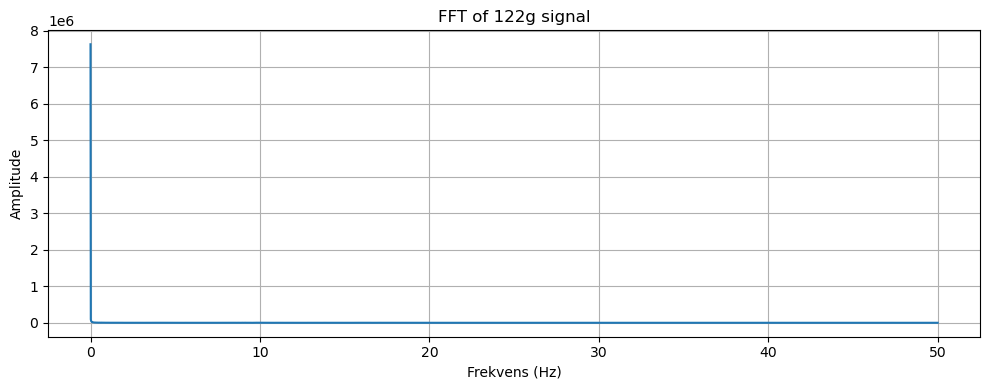

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Indlæs .txt-filen
file_path = "/Users/linnthomsen/Desktop/Skole/DTU/6thSemester/BA/FSR_software/Mass_FSR_analog/122g.txt"
data = np.loadtxt(file_path, delimiter=",")  # Indlæser begge kolonner

time_ms = data[:, 0]
signal = data[:, 1]

# 2. Beregn sampling rate (fs) fra tid (i millisekunder)
time_s = time_ms / 1000  # konverter til sekunder
dt = np.mean(np.diff(time_s))  # gennemsnitligt sample-interval
fs = 1 / dt  # sample rate i Hz

# 3. FFT
N = len(signal)
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(N, d=dt)

# 4. Kun positive frekvenser
pos_mask = fft_freqs >= 0
fft_freqs = fft_freqs[pos_mask]
fft_magnitude = np.abs(fft_vals[pos_mask])

# 5. Beregn middelværdi
mean_analog = np.mean(signal)
print(f"Mean of analogRead: {mean_analog:.2f}")

mean_voltage = mean_analog * 3.3 / 4095
print(f"Mean in Voltage: {mean_voltage:.2f} V")

Mass = 122
print(f"Kraft = {Mass * 0.00981:.4f} N")

# 6. Plot
plt.figure(figsize=(10, 4))
plt.plot(fft_freqs, fft_magnitude)
plt.title("FFT of 122g signal")
plt.xlabel("Frekvens (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


# 183g: Signal Processing and Power Spectrum Analysis

Mean analogRead: 2003.25
Standardafvigelse: 18.69


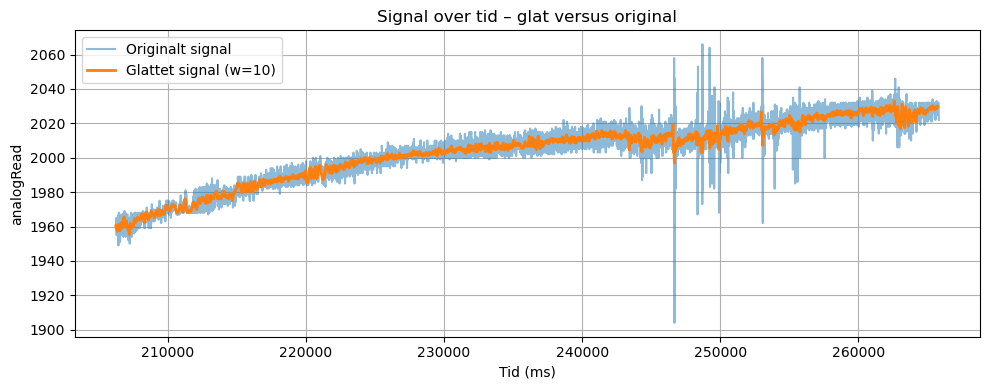

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Indlæs filen
file_path = "/Users/linnthomsen/Desktop/Skole/DTU/6thSemester/BA/FSR_software/Mass_FSR_analog/183g.txt"
data = np.loadtxt(file_path, delimiter=",")
time_ms = data[:, 0]
signal = data[:, 1]

# Beregn og print statistik
mean_analog = np.mean(signal)
std_dev = np.std(signal)
print(f"Mean analogRead: {mean_analog:.2f}")
print(f"Standardafvigelse: {std_dev:.2f}")

# >>> Her indsætter du moving average-funktionen:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

smooth = moving_average(signal, 10)

# Tid skal forkortes tilsvarende (fordi signalet bliver kortere)
time_smooth = time_ms[:len(smooth)]

# Plot originalt og glattet signal
plt.figure(figsize=(10, 4))
plt.plot(time_ms, signal, label="Originalt signal", alpha=0.5)
plt.plot(time_smooth, smooth, label="Glattet signal (w=10)", linewidth=2)
plt.xlabel("Tid (ms)")
plt.ylabel("analogRead")
plt.title("Signal over tid – glat versus original")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Mean of analogRead: 2003.25
Mean in Voltage: 1.61 V
Kraft = 1.7952 N


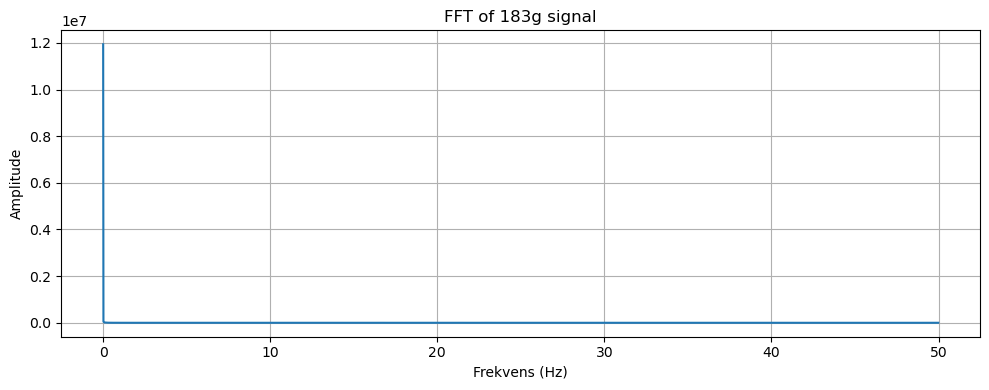

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Indlæs .txt-filen
file_path = "/Users/linnthomsen/Desktop/Skole/DTU/6thSemester/BA/FSR_software/Mass_FSR_analog/183g.txt"
data = np.loadtxt(file_path, delimiter=",")  # Indlæser begge kolonner

time_ms = data[:, 0]
signal = data[:, 1]

# 2. Beregn sampling rate (fs) fra tid (i millisekunder)
time_s = time_ms / 1000  # konverter til sekunder
dt = np.mean(np.diff(time_s))  # gennemsnitligt sample-interval
fs = 1 / dt  # sample rate i Hz

# 3. FFT
N = len(signal)
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(N, d=dt)

# 4. Kun positive frekvenser
pos_mask = fft_freqs >= 0
fft_freqs = fft_freqs[pos_mask]
fft_magnitude = np.abs(fft_vals[pos_mask])

# 5. Beregn middelværdi
mean_analog = np.mean(signal)
print(f"Mean of analogRead: {mean_analog:.2f}")

mean_voltage = mean_analog * 3.3 / 4095
print(f"Mean in Voltage: {mean_voltage:.2f} V")

Mass = 183
print(f"Kraft = {Mass * 0.00981:.4f} N")

# 6. Plot
plt.figure(figsize=(10, 4))
plt.plot(fft_freqs, fft_magnitude)
plt.title("FFT of 183g signal")
plt.xlabel("Frekvens (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


# 244g: Signal Processing and Power Spectrum Analysis

Mean analogRead: 2347.49
Standardafvigelse: 9.80


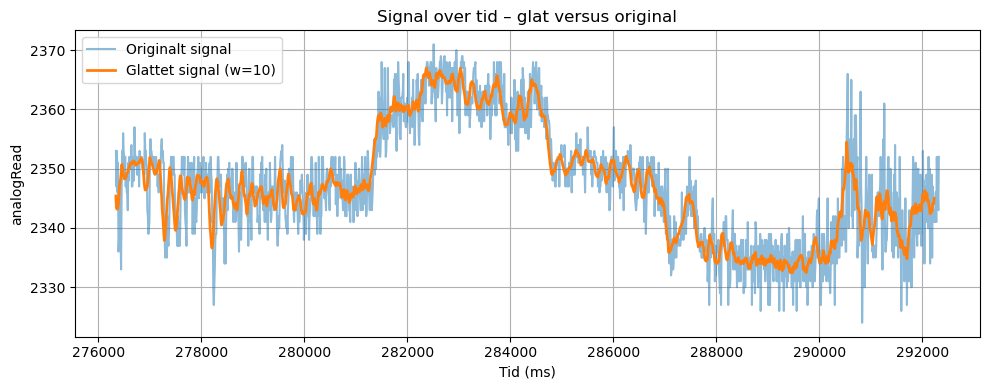

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Indlæs filen
file_path = "/Users/linnthomsen/Desktop/Skole/DTU/6thSemester/BA/FSR_software/Mass_FSR_analog/244g.txt"
data = np.loadtxt(file_path, delimiter=",")
time_ms = data[:, 0]
signal = data[:, 1]

# Beregn og print statistik
mean_analog = np.mean(signal)
std_dev = np.std(signal)
print(f"Mean analogRead: {mean_analog:.2f}")
print(f"Standardafvigelse: {std_dev:.2f}")

# >>> Her indsætter du moving average-funktionen:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

smooth = moving_average(signal, 10)

# Tid skal forkortes tilsvarende (fordi signalet bliver kortere)
time_smooth = time_ms[:len(smooth)]

# Plot originalt og glattet signal
plt.figure(figsize=(10, 4))
plt.plot(time_ms, signal, label="Originalt signal", alpha=0.5)
plt.plot(time_smooth, smooth, label="Glattet signal (w=10)", linewidth=2)
plt.xlabel("Tid (ms)")
plt.ylabel("analogRead")
plt.title("Signal over tid – glat versus original")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Mean of analogRead: 2347.49
Mean in Voltage: 1.89 V
Kraft = 2.3936 N


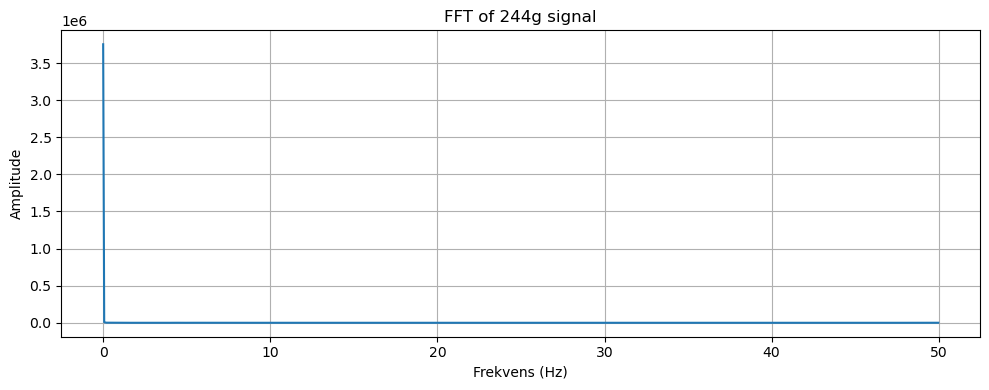

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Indlæs .txt-filen
file_path = "/Users/linnthomsen/Desktop/Skole/DTU/6thSemester/BA/FSR_software/Mass_FSR_analog/244g.txt"
data = np.loadtxt(file_path, delimiter=",")  # Indlæser begge kolonner

time_ms = data[:, 0]
signal = data[:, 1]

# 2. Beregn sampling rate (fs) fra tid (i millisekunder)
time_s = time_ms / 1000  # konverter til sekunder
dt = np.mean(np.diff(time_s))  # gennemsnitligt sample-interval
fs = 1 / dt  # sample rate i Hz

# 3. FFT
N = len(signal)
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(N, d=dt)

# 4. Kun positive frekvenser
pos_mask = fft_freqs >= 0
fft_freqs = fft_freqs[pos_mask]
fft_magnitude = np.abs(fft_vals[pos_mask])

# 5. Beregn middelværdi
mean_analog = np.mean(signal)
print(f"Mean of analogRead: {mean_analog:.2f}")

mean_voltage = mean_analog * 3.3 / 4095
print(f"Mean in Voltage: {mean_voltage:.2f} V")

Mass = 244
print(f"Kraft = {Mass * 0.00981:.4f} N")

# 6. Plot
plt.figure(figsize=(10, 4))
plt.plot(fft_freqs, fft_magnitude)
plt.title("FFT of 244g signal")
plt.xlabel("Frekvens (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


# Trend for Hjemme test med shotsglas og køkkenvægt ud fra dataet

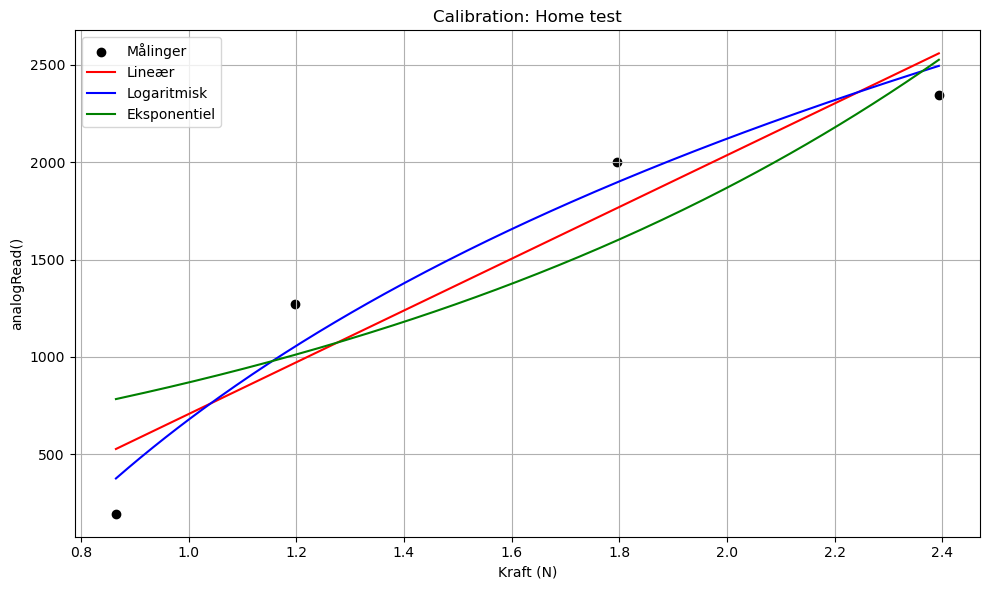

Lineær model:       y = 1329.2607 * x + -622.4325
Logaritmisk model:  y = 2081.8905 * ln(x) + 677.8834
Eksponentiel model: y = 404.1867 * e^(0.76565 * x)


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Dine data
analog_read = np.array([195.21, 1273.13, 2003.25, 2347.49])
force_n = np.array([0.8651, 1.1968, 1.7952, 2.3936])

# Model 1: Lineær
def linear_model(x, a, b):
    return a * x + b

# Model 2: Logaritmisk
def log_model(x, a, b):
    return a * np.log(x) + b

# Model 3: Eksponentiel
def exp_model(x, a, b):
    return a * np.exp(b * x)

# Fit modeller (nu: x = force, y = analog_read)
params_linear, _ = curve_fit(linear_model, force_n, analog_read)
params_log, _ = curve_fit(log_model, force_n, analog_read)
params_exp, _ = curve_fit(exp_model, force_n, analog_read, p0=(1e-6, 1), maxfev=10000)

# X til graf
x_fit = np.linspace(min(force_n), max(force_n), 200)
y_linear = linear_model(x_fit, *params_linear)
y_log = log_model(x_fit, *params_log)
y_exp = exp_model(x_fit, *params_exp)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(force_n, analog_read, color="black", label="Målinger")
plt.plot(x_fit, y_linear, label="Lineær", color="red")
plt.plot(x_fit, y_log, label="Logaritmisk", color="blue")
plt.plot(x_fit, y_exp, label="Eksponentiel", color="green")
plt.title("Calibration: Home test")
plt.xlabel("Kraft (N)")
plt.ylabel("analogRead()")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Udskriv ligninger med parametre
print(f"Lineær model:       y = {params_linear[0]:.4f} * x + {params_linear[1]:.4f}")
print(f"Logaritmisk model:  y = {params_log[0]:.4f} * ln(x) + {params_log[1]:.4f}")
print(f"Eksponentiel model: y = {params_exp[0]:.4f} * e^({params_exp[1]:.5f} * x)")


# Hypotese og undersøgelse: Silikone og trykdrift over tid


Hypotese:
Jo længere tid vægten ligger på silikonen og FSR’en, desto mere trykkes silikonen flad → hvilket medfører, at kraften fordeles mere direkte på den følsomme del af FSR’en. Det resulterer i en stigende målt værdi (analogRead) over tid, selvom vægten er konstant.

Baggrund:
Silikone er et blødt og formbart materiale, som over tid kan deformeres under statisk belastning. Denne langsomme ændring i form kan betyde, at kontakten til FSR’en bliver mere effektiv, eller at kraften koncentreres bedre – hvilket kan skabe en falsk "stigning" i signalet over tid.

Undersøgelse:

Udføre langtidsmåling med konstant vægt i 90 sek. 

Gentager både med og uden silikone

Bruger lineær regression til at vurdere om signalet stiger

Sammenligner kurver, hældning og variation

Formål:
At dokumentere om silikonen introducerer en systematisk fejl i form af trykdrift over tid, som skal tages højde for ved kalibrering og fortolkning af data.


Slope: 0.84964 (ændring i analogRead per sekund)
R²: 0.759 – forklaringsgrad


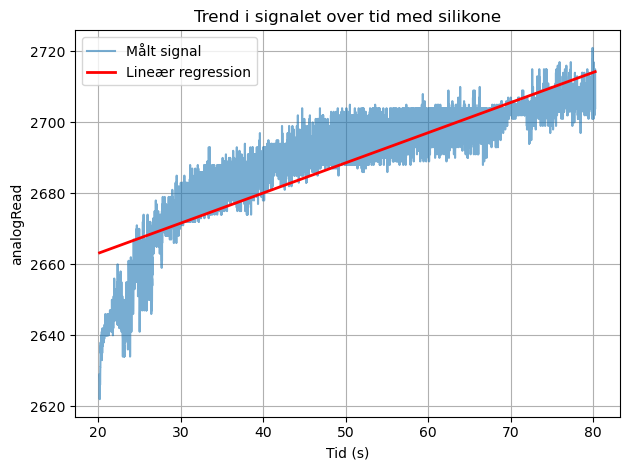

In [54]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# 1. Indlæs din fil (TXT med tid, analogRead)
file_path = "/Users/linnthomsen/Desktop/Skole/DTU/6thSemester/BA/FSR_software/Mass_FSR_analog/MSili_995g.txt"
data = np.loadtxt(file_path, delimiter=",")  # eller delimiter=";" hvis du bruger Excel-CSV

# 2. Adskil kolonner og konverter tid
time_ms = data[:, 0]
signal = data[:, 1]
time_s = time_ms / 1000  # konverter til sekunder

# 3. Kør lineær regression
slope, intercept, r_value, p_value, std_err = linregress(time_s, signal)

# 4. Print resultater
print(f"Slope: {slope:.5f} (ændring i analogRead per sekund)")
print(f"R²: {r_value**2:.3f} – forklaringsgrad")

# 5. (valgfrit) Visualisér regressionen
fit_line = slope * time_s + intercept

plt.plot(time_s, signal, label="Målt signal", alpha=0.6)
plt.plot(time_s, fit_line, label="Lineær regression", color="red", linewidth=2)
plt.xlabel("Tid (s)")
plt.ylabel("analogRead")
plt.title("Trend i signalet over tid med silikone")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Slope: 2.08770 (ændring i analogRead per sekund)
R²: 0.959 – forklaringsgrad


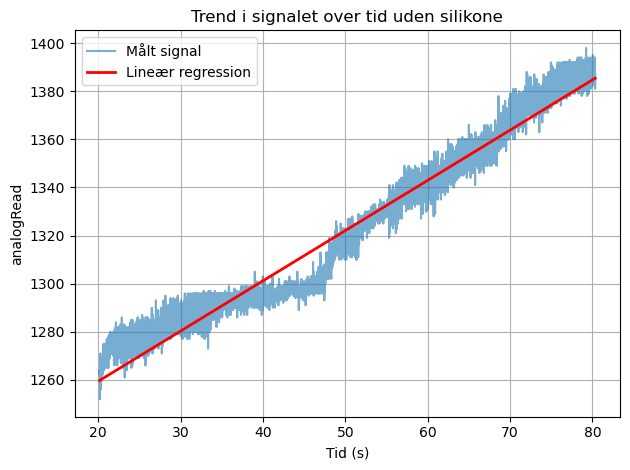

In [55]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# 1. Indlæs din fil (TXT med tid, analogRead)
file_path = "/Users/linnthomsen/Desktop/Skole/DTU/6thSemester/BA/FSR_software/Mass_FSR_analog/USili_295g.txt"
data = np.loadtxt(file_path, delimiter=",")  # eller delimiter=";" hvis du bruger Excel-CSV

# 2. Adskil kolonner og konverter tid
time_ms = data[:, 0]
signal = data[:, 1]
time_s = time_ms / 1000  # konverter til sekunder

# 3. Kør lineær regression
slope, intercept, r_value, p_value, std_err = linregress(time_s, signal)

# 4. Print resultater
print(f"Slope: {slope:.5f} (ændring i analogRead per sekund)")
print(f"R²: {r_value**2:.3f} – forklaringsgrad")

# 5. (valgfrit) Visualisér regressionen
fit_line = slope * time_s + intercept

plt.plot(time_s, signal, label="Målt signal", alpha=0.6)
plt.plot(time_s, fit_line, label="Lineær regression", color="red", linewidth=2)
plt.xlabel("Tid (s)")
plt.ylabel("analogRead")
plt.title("Trend i signalet over tid uden silikone")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Selvom det var forventet, at silikonen ville medføre en stigende måling over tid pga. komprimering, viste resultaterne det modsatte: signalet steg markant mere uden silikone. Dette antyder, at silikonen i stedet virker dæmpende og med til at stabilisere kraftfordelingen mod FSR’en over tid.

# high pass filter

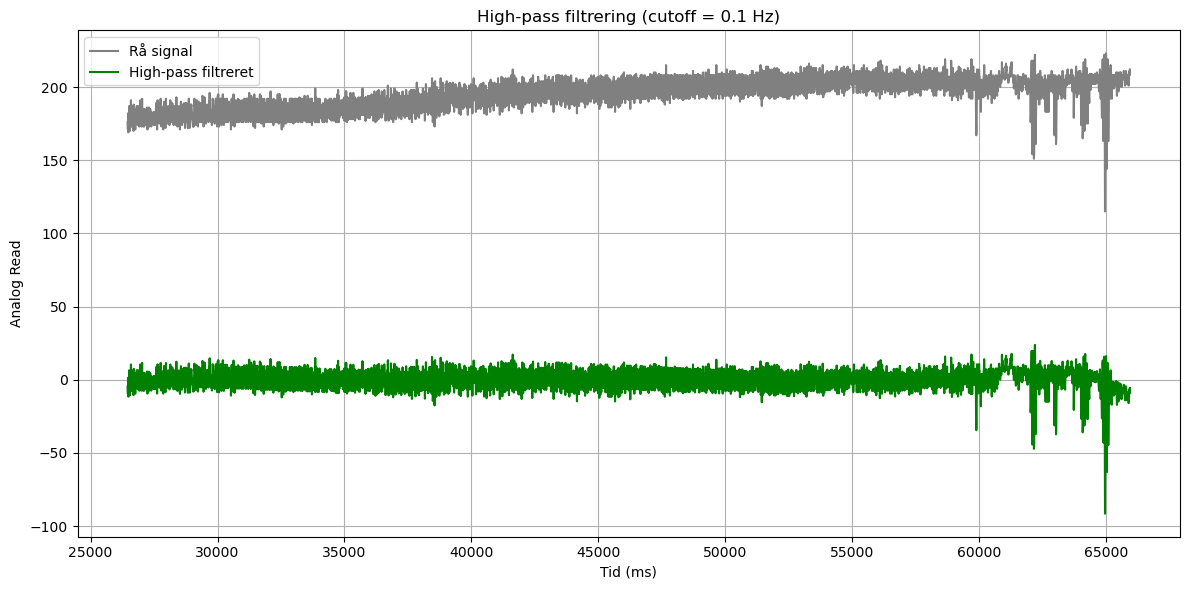

In [3]:
from scipy.signal import butter, filtfilt

# High-pass filter funktion
def highpass_filter(data, cutoff=0.1, fs=100, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

# Justér sampling rate (fx 100 Hz hvis det passer dit datasæt)
fs = 100  # Hz
filtered_signal = highpass_filter(signal, cutoff=0.1, fs=fs)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(time_ms, signal, label="Rå signal", color="gray")
plt.plot(time_ms, filtered_signal, label="High-pass filtreret", color="green")
plt.legend()
plt.title("High-pass filtrering (cutoff = 0.1 Hz)")
plt.xlabel("Tid (ms)")
plt.ylabel("Analog Read")
plt.grid(True)
plt.tight_layout()
plt.show()
